## Perturbation of sequences
### Dataset: SARS-CoV-2 aligned w.r.t WIV04
### Number of sequences = 94 (93 + 1) 
### Model: VirProBERT (CoV-S-UniRef90, CoV-S-UniRef90-aligned) 

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniref90',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniref90/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniref90/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniref90/..']

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [3]:
human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/cov-S-aligned-binary-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
perturbation_output_files = os.listdir(perturbation_processed_output_dir)
len(perturbation_output_files)

94

In [4]:
perturbed_output_dfs = []
for perturbation_output_file in perturbation_output_files:
    df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    df[pred_diff_col] = df[human_label] - orig_pred_val
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    perturbed_output_dfs.append(df)
perturbed_output_df = pd.concat(perturbed_output_dfs)

In [5]:
print(perturbed_output_df.shape)
perturbed_output_df.head()

(2978369, 9)


,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff
0,0.988160,0.011840,UniRef90_A0A8B6RAI1,Human,X,768,N,0.000013,0.000013
1,0.988147,0.011853,UniRef90_A0A8B6RAI1,Human,I,1718,B,0.000000,0.000000
2,0.988147,0.011853,UniRef90_A0A8B6RAI1,Human,R,1622,T,0.000000,0.000000
3,0.988334,0.011666,UniRef90_A0A8B6RAI1,Human,X,127,I,0.000186,0.000186
4,0.988147,0.011853,UniRef90_A0A8B6RAI1,Human,A,1691,H,0.000000,0.000000


### WIV04 reference sequence

In [6]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..",  "input/data/coronaviridae/20240313/uniref/aligned/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniref90_id"] == "WIV04"]
wiv04_df.head()

,uniref90_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [7]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
wiv04_aligned_seq

'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [8]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = pos
        
try:
    perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)
except: 
    pass

### Distribution of prediction difference values

/tmp/ipykernel_3244821/2860024834.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(perturbed_output_df["Human_pred_diff"])


<Figure size 432x288 with 0 Axes>

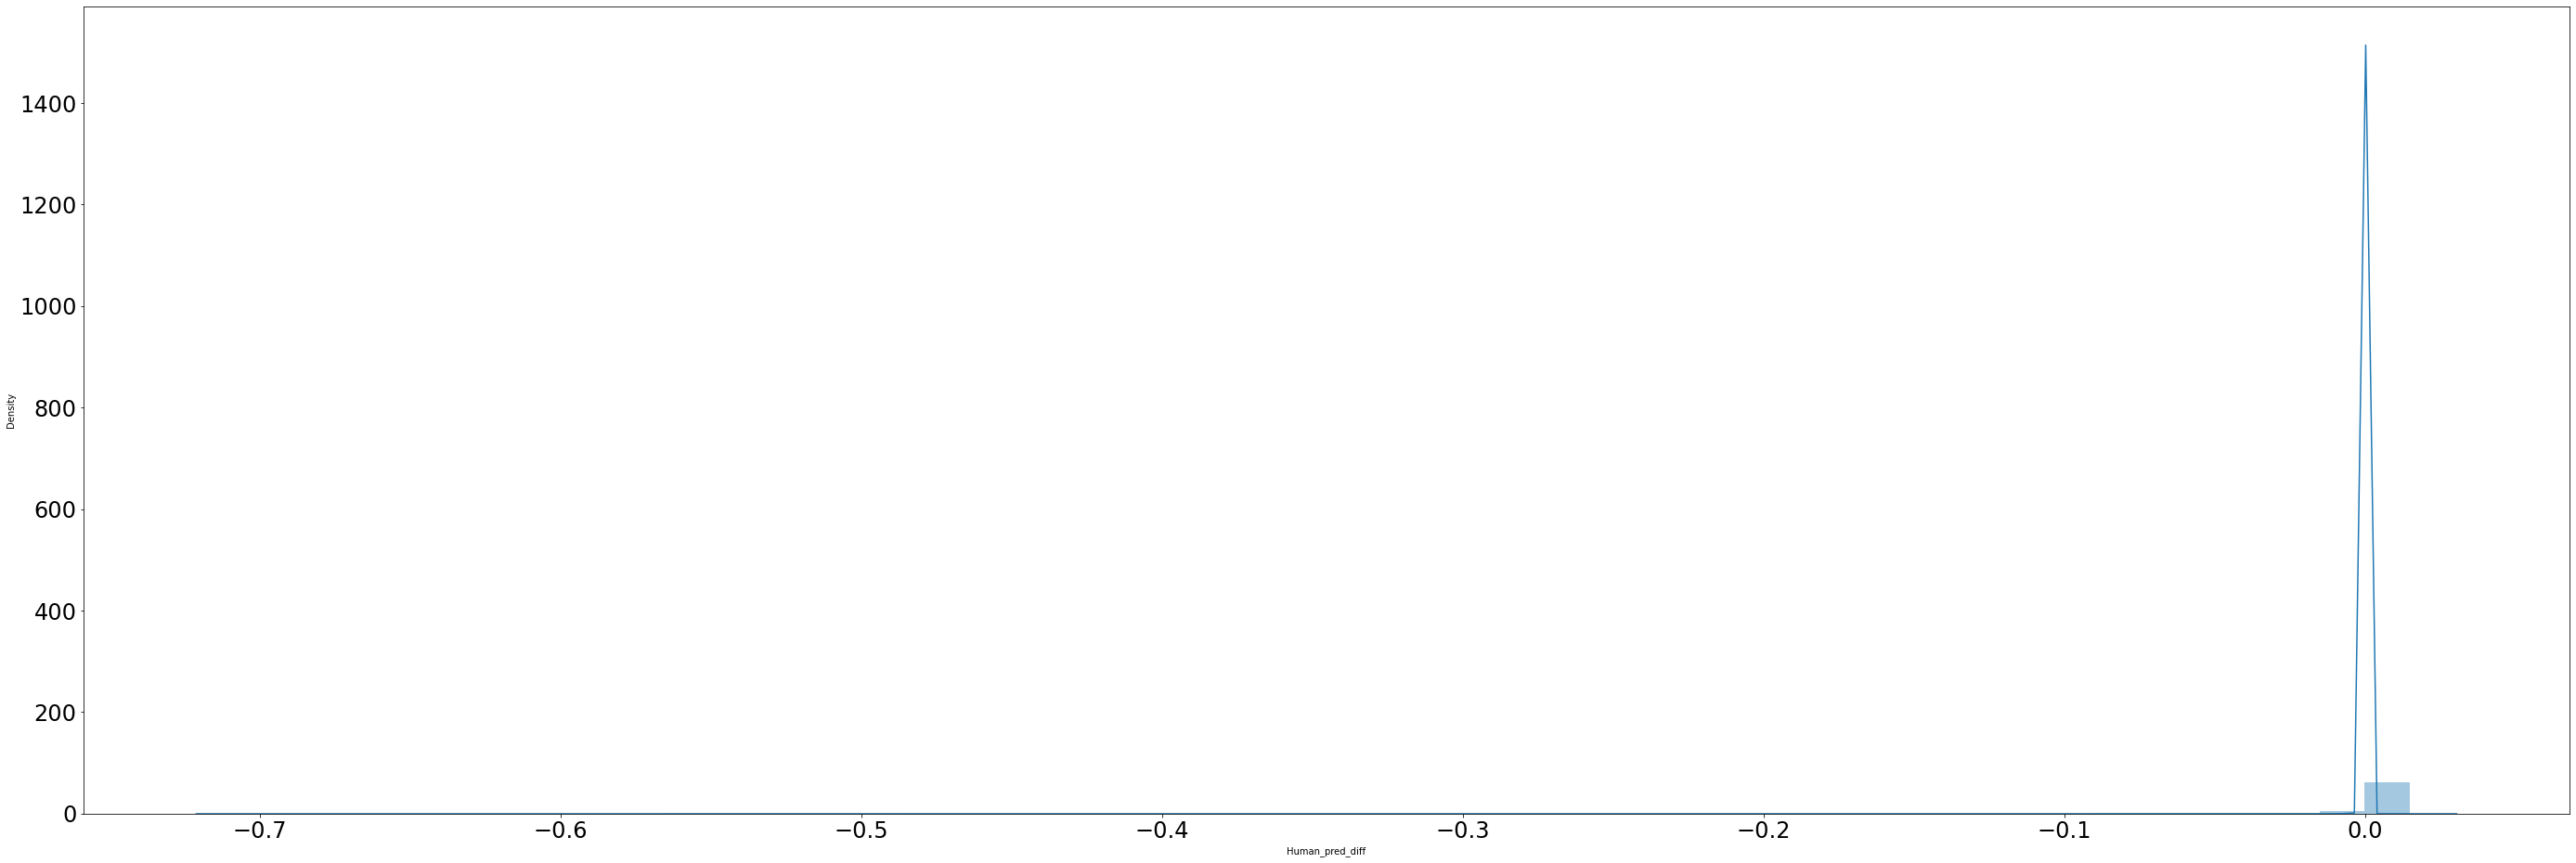

In [9]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
sns.distplot(perturbed_output_df["Human_pred_diff"])
plt.show()

In [10]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df[pred_diff_col], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})
    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.720684,-0.658142,6,0.000201
1,-0.658142,-0.595600,5,0.000168
2,-0.595600,-0.533057,19,0.000638
3,-0.533057,-0.470515,14,0.000470
4,-0.470515,-0.407973,19,0.000638
5,-0.407973,-0.345430,34,0.001142
6,-0.345430,-0.282888,43,0.001444
7,-0.282888,-0.220346,74,0.002485
8,-0.220346,-0.157803,52,0.001746
9,-0.157803,-0.095261,41,0.001377


In [11]:
perturbed_output_df_selected = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] > 0.1]
print(f"Number of sequences = {perturbed_output_df_selected.shape[0]}")
print(f"Number of unique positions = {len(perturbed_output_df_selected['perturb_seq_pos'].unique())}")
print(f"Unique positions = {perturbed_output_df_selected['perturb_seq_pos'].unique()}")

Number of sequences = 301
Number of unique positions = 6
Unique positions = [402. 401. 409. 403. 452. 458.]


In [12]:
perturbed_output_df_selected["experiment"] = "sarscov2-uniref90-aligned-binary"
perturbation_selected_output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniref90_aligned_binary.csv")
perturbed_output_df_selected.to_csv(perturbation_selected_output_file_path, index=False)

/tmp/ipykernel_3244821/2695115289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["experiment"] = "sarscov2-uniref90-aligned-binary"


### Top 10 perturbations with highest change in prediction probability

In [13]:
perturbed_output_df_selected.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)


,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment
29169,0.256521,0.743479,UniRef90_A0A8B6RNC0,Human,I,1069,L,-0.720684,0.720684,402.0,sarscov2-uniref90-aligned-binary
26323,0.261708,0.738292,UniRef90_A0A8B1JB63,Human,V,1068,L,-0.715977,0.715977,401.0,sarscov2-uniref90-aligned-binary
20033,0.264555,0.735445,UniRef90_A0A8B6RNC0,Human,V,1068,L,-0.712650,0.712650,401.0,sarscov2-uniref90-aligned-binary
23461,0.266514,0.733486,UniRef90_A0A8B1JB63,Human,I,1069,L,-0.711171,0.711171,402.0,sarscov2-uniref90-aligned-binary
18579,0.310273,0.689727,UniRef90_A0A8B1JIJ6,Human,V,1068,L,-0.669402,0.669402,401.0,sarscov2-uniref90-aligned-binary
25791,0.320661,0.679339,UniRef90_A0A8B1JIJ6,Human,I,1069,L,-0.659014,0.659014,402.0,sarscov2-uniref90-aligned-binary
9781,0.336345,0.663655,WIV04,Human,V,1068,L,-0.641858,0.641858,401.0,sarscov2-uniref90-aligned-binary
30002,0.344989,0.655011,UniRef90_A0A8B1JR91,Human,V,1068,L,-0.637040,0.637040,401.0,sarscov2-uniref90-aligned-binary
19600,0.361662,0.638338,WIV04,Human,I,1069,L,-0.616540,0.616540,402.0,sarscov2-uniref90-aligned-binary
25636,0.368444,0.631556,UniRef90_A0A8B1JR91,Human,I,1069,L,-0.613585,0.613585,402.0,sarscov2-uniref90-aligned-binary


In [14]:
perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)
perturbed_output_df_selected.head()

/tmp/ipykernel_3244821/2825421286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)


,Human,Non-Human,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment,perturbation_id
2978,0.590175,0.409825,UniRef90_A0A8B6RAI1,Human,I,1069,L,-0.397972,0.397972,402.0,sarscov2-uniref90-aligned-binary,402.0_L
15899,0.571952,0.428048,UniRef90_A0A8B6RAI1,Human,V,1068,L,-0.416195,0.416195,401.0,sarscov2-uniref90-aligned-binary,401.0_L
20944,0.863793,0.136207,UniRef90_A0A8B6RAI1,Human,Q,1076,L,-0.124355,0.124355,409.0,sarscov2-uniref90-aligned-binary,409.0_L
28984,0.741563,0.258438,UniRef90_A0A8B6RAI1,Human,R,1070,L,-0.246585,0.246585,403.0,sarscov2-uniref90-aligned-binary,403.0_L
9976,0.852662,0.147338,UniRef90_A0A8B6RJG7,Human,Q,1076,L,-0.135196,0.135196,409.0,sarscov2-uniref90-aligned-binary,409.0_L


In [15]:
mean_diff_df = perturbed_output_df_selected[["perturbation_id", "abs_Human_pred_diff"]].groupby("perturbation_id").mean(pred_diff_col)

In [16]:
mean_diff_df = mean_diff_df.reset_index()

In [17]:
mean_diff_df[["perturb_seq_pos", "new_token"]] = mean_diff_df["perturbation_id"].str.split("_", expand=True)

In [18]:
mean_diff_df.head()

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
0,401.0_L,0.381023,401.0,L
1,402.0_L,0.357249,402.0,L
2,403.0_L,0.243152,403.0,L
3,409.0_L,0.185258,409.0,L
4,452.0_H,0.133646,452.0,H


In [19]:
mean_diff_df[mean_diff_df[["perturb_seq_pos", "new_token"]].duplicated()]

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token


In [20]:
df = mean_diff_df.pivot(columns="perturb_seq_pos", index="new_token", values="abs_Human_pred_diff")
# df[token_positions]

In [21]:
mean_diff_df.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
0,401.0_L,0.381023,401.0,L
1,402.0_L,0.357249,402.0,L
2,403.0_L,0.243152,403.0,L
3,409.0_L,0.185258,409.0,L
4,452.0_H,0.133646,452.0,H
5,458.0_H,0.125671,458.0,H


<Figure size 432x288 with 0 Axes>

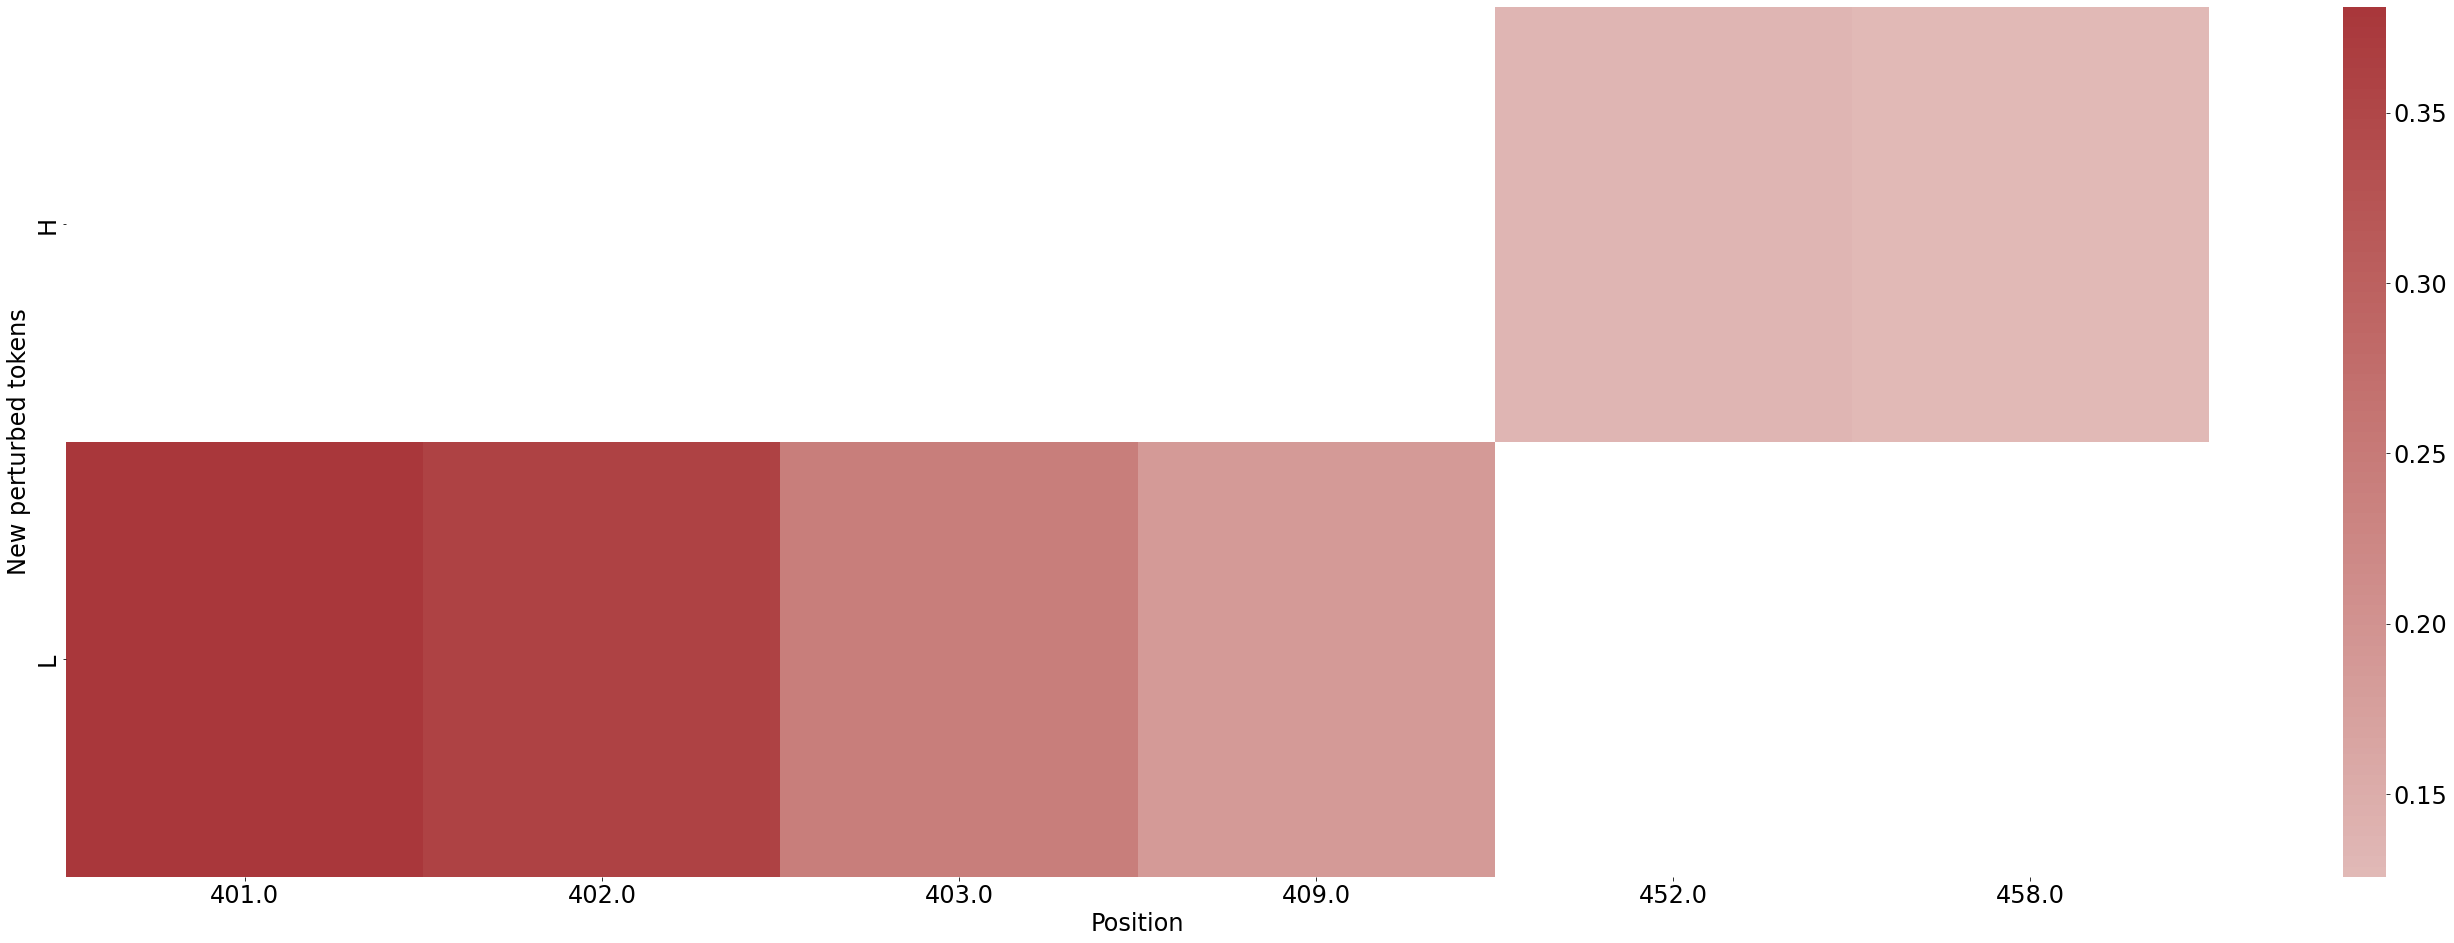

In [22]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
# plt.rcParams['figure.autolayout'] = True
ax = sns.heatmap(df, cmap=cmap, center=0)
plt.xlabel('Position', fontsize=24)
plt.ylabel('New perturbed tokens', fontsize=24)
plt.show()

In [23]:
df.mean(axis=0)

perturb_seq_pos
401.0    0.381023
402.0    0.357249
403.0    0.243152
409.0    0.185258
452.0    0.133646
458.0    0.125671
dtype: float64

<Figure size 432x288 with 0 Axes>

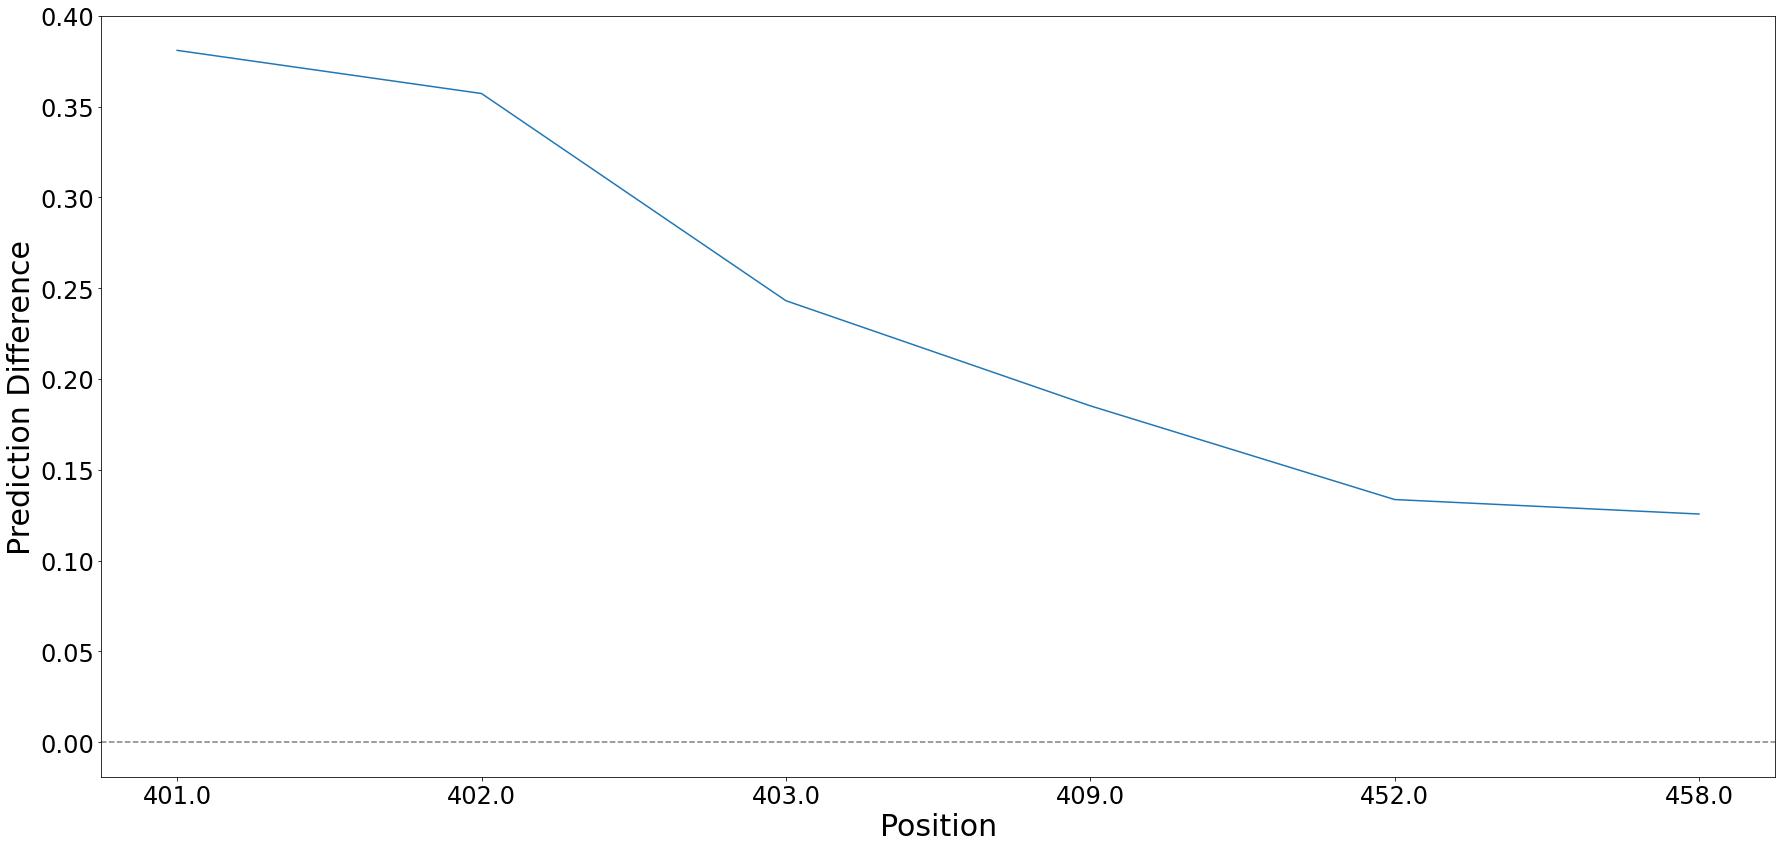

In [24]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
ax.axhline(0.0, color="gray", linestyle="--")
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.xlabel('Position', fontsize=30)
plt.ylabel('Prediction Difference', fontsize=30)
#ax.set_xlim(0, 1273)
plt.show()